In [1]:
from dataclasses import dataclass
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms

@dataclass
class Config:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "samples"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = Config()
config.dataset_name = "data"

In [13]:
from diffusers import DDPMPipeline

def generate(pipeline, num_images=1, config=config, seed = None):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=num_images,
        # random seed for reproducibility
        generator=torch.Generator(device='cpu').manual_seed(seed) if seed is not None else None,
    ).images
    return images

# Load the trained pipeline
pipeline = DDPMPipeline.from_pretrained(config.output_dir)

# Ensure pipeline is set to evaluation mode
pipeline.unet.eval()

# Define the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pipeline.to(device)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

cuda


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "samples",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

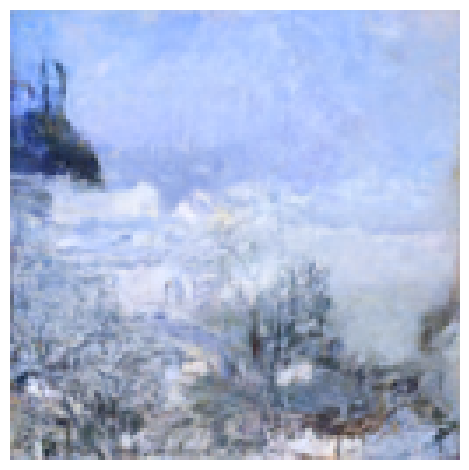

In [15]:

# Generate images (now passing pipeline, not config)
images = generate(pipeline, num_images=1, seed = 11)  # Example: generating 1 image

# Calculate exact grid dimensions
from diffusers.utils import make_image_grid
# only 8 first
num_images = len(images)
cols = min(num_images, 4)  # Max 4 columns
rows = (num_images + cols - 1) // cols  # Compute rows to fit all images
# Make a grid out of the images 4 columns and the rest rows

image_grid = make_image_grid(images, rows=rows, cols=cols)
plt.imshow(image_grid)
plt.axis("off")
plt.tight_layout()
plt.show()